# Libraries

In [1]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# reading data
from os.path import basename
import json
from collections import defaultdict
import glob
import re

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Read in Results

In [2]:
# Define the pattern to match the filenames
pattern = "df_(.*?)_(.*?)_emb(.*?)_(.*?).csv"

# Use glob to find all csv files matching the pattern
files = glob.glob('../data/Results/df_*_*_emb*_*.csv')

# Initialize a dictionary to hold the data frames
data_frames = {}

for file in files:
    # Extract the basename of the file for regex matching
    file_basename = basename(file)
    
    # Extract model name, embedding length, and loss function using regex
    match = re.match(pattern, file_basename)
    if match:
        result_type = match.group(1)
        model_name = match.group(2)
        embedding_length = match.group(3)
        loss_function = match.group(4)

        # Read the csv file into a pandas DataFrame
        df = pd.read_csv(file)

        # Store the DataFrame in the dictionary with a tuple key for easy sorting
        data_frames[(result_type, model_name, int(embedding_length), loss_function)] = df
    else:
        # If no match, print the filename for review
        print(f"No match for file: {file_basename}")

In [3]:
def SystemUsage_LaTeX(data_frames, model_type='Linear', embedding_lengths=[32, 64, 128], loss_functions=['CRPS', 'MSELoss', 'L1Loss', 'CrossEntropyLoss']):
    """
    Generates LaTeX table code with system usage statistics filled in for given model types,
    loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - embedding_lengths: List of embedding lengths to include in the table.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, embedding_length): {'max_cpu': '', 'max_ram': '', 'max_gpu': '', 'avg_cpu': '', 'avg_ram': '', 'avg_gpu': ''} 
             for loss_function in loss_functions for embedding_length in embedding_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'SystemUsage' and key[1] == model_type and key[2] in embedding_lengths and key[3] in loss_functions:
            stats_key = (key[3], key[2])
            # Update stats with maximum values
            stats[stats_key]['max_cpu'] = round(system_df['CPU Usage'][1:].max(), 4)
            stats[stats_key]['max_ram'] = round(system_df['Memory Usage (GB)'].max(), 4)
            stats[stats_key]['max_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].max(), 4)
            # Update stats with average values
            stats[stats_key]['avg_cpu'] = round(system_df['CPU Usage'][1:].mean(), 4)
            stats[stats_key]['avg_ram'] = round(system_df['Memory Usage (GB)'].mean(), 4)
            stats[stats_key]['avg_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].mean(), 4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\centering
    \\begin{tabular}{l|l|S|S|S|S|S|S}
        \\toprule
        \\textbf{Loss Function} & \\textbf{Embedding Length} & \\multicolumn{3}{c|}{\\textbf{max Usage}} & \\multicolumn{3}{c}{\\textbf{avg Usage}} \\\\
        & & CPU & RAM & GPU & CPU & RAM & GPU \\\\
        \\midrule
    """
    for embedding_length in embedding_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, embedding_length)]
            latex_table += f"        {loss_function} & {embedding_length} & "
            latex_table += f"{stat['max_cpu']} & {stat['max_ram']} & {stat['max_gpu']} & "
            latex_table += f"{stat['avg_cpu']} & {stat['avg_ram']} & {stat['avg_gpu']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\caption{""" + model_type + """ Model Hardware Results}
    \\label{tab:""" + model_type.lower() + """_hardware_results}
\\end{table}"""

    print(latex_table)

SystemUsage_LaTeX(data_frames, model_type='Linear')

\begin{table}
    \centering
    \begin{tabular}{l|l|S|S|S|S|S|S}
        \toprule
        \textbf{Loss Function} & \textbf{Embedding Length} & \multicolumn{3}{c|}{\textbf{max Usage}} & \multicolumn{3}{c}{\textbf{avg Usage}} \\
        & & CPU & RAM & GPU & CPU & RAM & GPU \\
        \midrule
            CRPS & 32 &  &  &  &  &  &  \\
        MSELoss & 32 &  &  &  &  &  &  \\
        L1Loss & 32 &  &  &  &  &  &  \\
        CrossEntropyLoss & 32 &  &  &  &  &  &  \\
        \midrule
        CRPS & 64 & 39.0 & 24.925 & 0.3965 & 15.5342 & 8.0879 & 0.393 \\
        MSELoss & 64 & 100.0 & 31.2111 & 0.4023 & 15.9607 & 12.0433 & 0.4023 \\
        L1Loss & 64 & 100.0 & 27.2164 & 0.4023 & 19.4865 & 14.1772 & 0.4023 \\
        CrossEntropyLoss & 64 & 22.0 & 36.8406 & 0.4023 & 15.2606 & 8.7524 & 0.4023 \\
        \midrule
        CRPS & 128 &  &  &  &  &  &  \\
        MSELoss & 128 &  &  &  &  &  &  \\
        L1Loss & 128 &  &  &  &  &  &  \\
        CrossEntropyLoss & 128 &  &  &  &  &  &  \\

In [4]:
def Epoch_LaTeX(data_frames, model_type='Linear', embedding_lengths=[32, 64, 128], loss_functions=['CRPS', 'MSELoss', 'L1Loss', 'CrossEntropyLoss']):
    """
    Generates LaTeX table code with Epoch statistics filled in for given model types, loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - embedding_lengths: List of embedding lengths to include in the table.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, embedding_length): {'epochs': '', 'training_time': ''} 
             for loss_function in loss_functions for embedding_length in embedding_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'epoch' and key[1] == model_type and key[2] in embedding_lengths and key[3] in loss_functions:
            stats_key = (key[3], key[2])
            # Update stats
            stats[stats_key]['epochs'] = len(system_df['Epoch Duration'])
            stats[stats_key]['training_time'] = round(sum(system_df['Epoch Duration']) / (60),4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\centering
    \\begin{tabular}{l|l|r|S}
        \\toprule
        \\textbf{Loss Function} & \\textbf{Embedding Length} & \\textbf{Epochs} & \\textbf{Training Time} \\\\
        \\midrule
    """
    for embedding_length in embedding_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, embedding_length)]
            latex_table += f"        {loss_function} & {embedding_length} & "
            latex_table += f"{stat['epochs']} & {stat['training_time']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\caption{""" + model_type + """ Model Training Results}
    \\label{tab:""" + model_type.lower() + """_training_results}
\\end{table}"""

    print(latex_table)

Epoch_LaTeX(data_frames, model_type='Linear')

\begin{table}
    \centering
    \begin{tabular}{l|l|r|S}
        \toprule
        \textbf{Loss Function} & \textbf{Embedding Length} & \textbf{Epochs} & \textbf{Training Time} \\
        \midrule
            CRPS & 32 &  &  \\
        MSELoss & 32 &  &  \\
        L1Loss & 32 &  &  \\
        CrossEntropyLoss & 32 &  &  \\
        \midrule
        CRPS & 64 & 13 & 19.4382 \\
        MSELoss & 64 & 30 & 43.9613 \\
        L1Loss & 64 & 24 & 35.2697 \\
        CrossEntropyLoss & 64 & 15 & 22.2349 \\
        \midrule
        CRPS & 128 &  &  \\
        MSELoss & 128 &  &  \\
        L1Loss & 128 &  &  \\
        CrossEntropyLoss & 128 &  &  \\
        \midrule
    \bottomrule
    \end{tabular}
    \caption{Linear Model Training Results}
    \label{tab:linear_training_results}
\end{table}


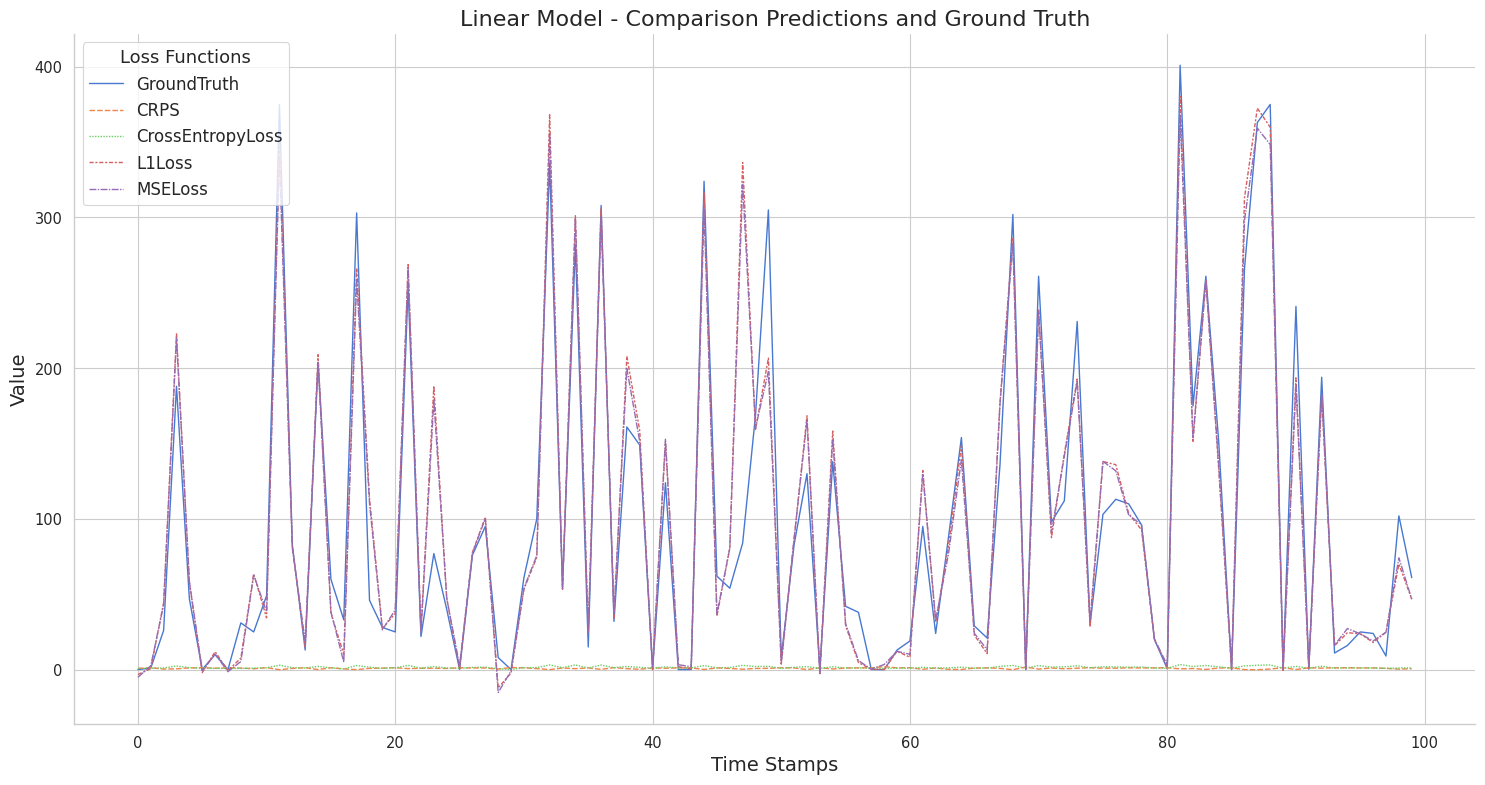

In [53]:
def eval_df(model, data_frames):
    """
    Aggregate predictions by model and loss function for 'eval' keys from the data frames.

    Parameters:
    - model: String value of the Model to test.
    - data_frames: Dictionary mapping keys to pandas DataFrames.

    Returns:
    - A pandas DataFrame with aggregated data, one column for each loss function's predictions.
    """
    # Initialize placeholders
    ground_truths = []
    predictions = {}
    
    # Loop over each key to process 'eval' data frames
    for key in data_frames.keys():
        if 'eval' in key and key[1] == model:
            _, model, _, loss_function = key
            df = data_frames[key]
            
            # Extend the ground truths if this is a larger set
            if len(df) > len(ground_truths):
                ground_truths = df['GroundTruth'].tolist()
            
            # Store predictions keyed by loss function
            predictions[loss_function] = df['Predictions'].tolist()
    
    # Determine the maximum length needed for any column
    max_length = max(len(ground_truths), max(len(pred) for pred in predictions.values()))
    
    # Pad all prediction lists to the max length with NaN
    for loss_function in predictions:
        current_length = len(predictions[loss_function])
        if current_length < max_length:
            predictions[loss_function].extend([np.nan] * (max_length - current_length))
    
    # Assemble the final DataFrame
    aggregated_data = {
        'Groundtruth': ground_truths[:max_length]
    }
    aggregated_data.update(predictions)
    
    aggregated_df = pd.DataFrame(aggregated_data)

    # Set the style of the plot to be suitable for a publication
    sns.set(style="whitegrid", context="paper", palette="muted", font_scale=1.2)
    # Create the plot
    plt.figure(figsize=(15, 8))
    lineplot = sns.lineplot(data=aggregated_df[:100], linewidth=1)

    # Customizing the plot
    title = f"{model} Model - Predictions and Ground Truth"
    plt.title(title, fontsize=16)
    plt.xlabel('Time Stamps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(title='Loss Functions', title_fontsize='13', fontsize='12', loc='upper left')
    sns.despine() # remove spines on right and top side
    plt.tight_layout() # prevent overlapping

    # Save the plot to a file
    plt.savefig(f'../graphs/results/{title}.png', dpi=600)

    # Show the plot
    plt.show()

eval_df('Linear', data_frames)

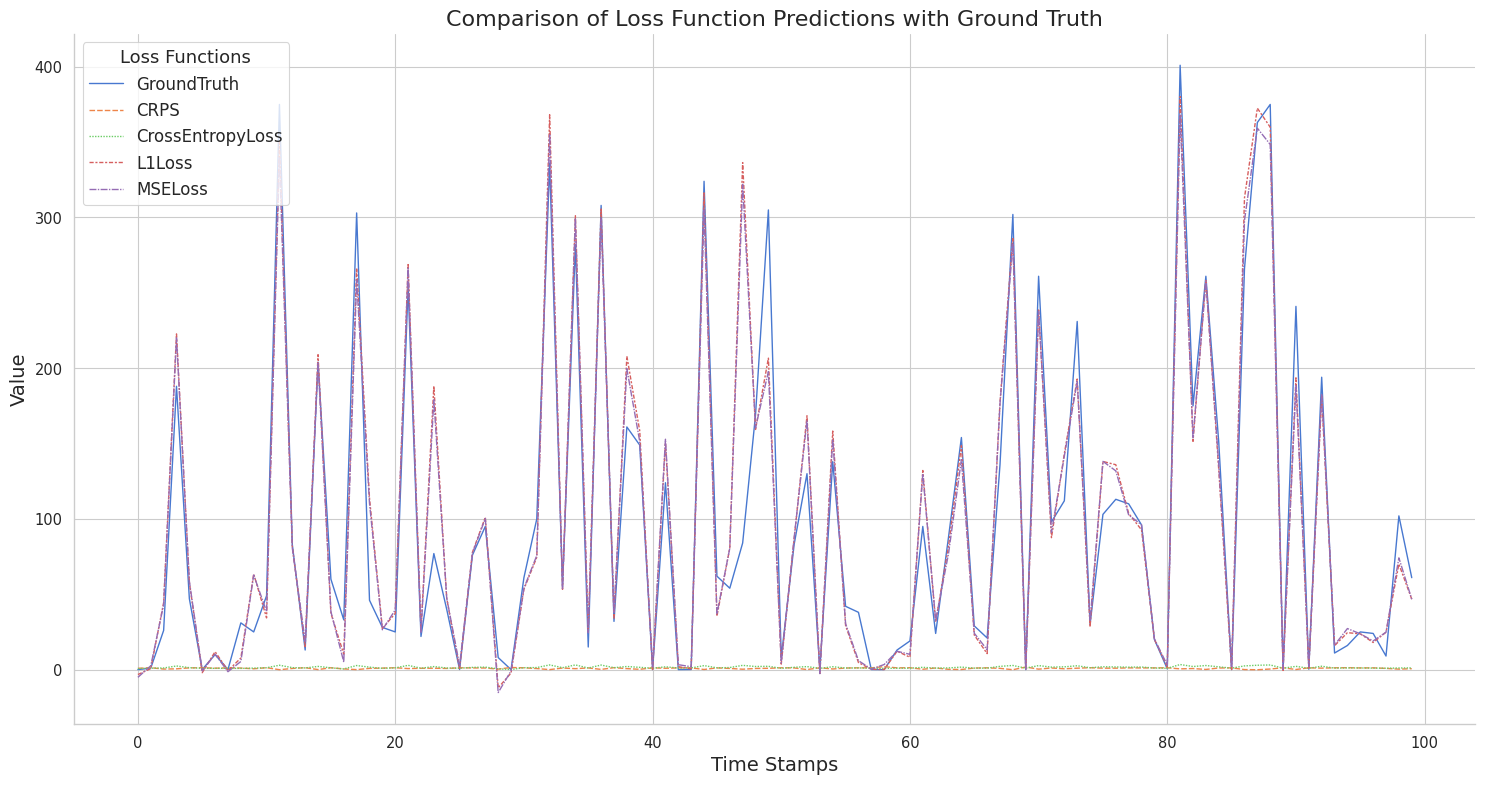

In [51]:
# Set the style of the plot to be suitable for a publication
sns.set(style="whitegrid", context="paper", palette="muted", font_scale=1.2)

# Create the plot
plt.figure(figsize=(15, 8))
lineplot = sns.lineplot(data=Linear_eval_df[:100], linewidth=1)

# Customizing the plot
title = f"{model} Model - Comparison Predictions and Ground Truth"
plt.title(title, fontsize=16)
plt.xlabel('Time Stamps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(title='Loss Functions', title_fontsize='13', fontsize='12', loc='upper left')

# Optional: Remove the top and right spines (for aesthetics)
sns.despine()

# Adjust the plot to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot to a file
plt.savefig(f'../graphs/results/{title}.png', dpi=600)

# Show the plot
plt.show()